# Functional Reparametrization Benchmarks

This notebook is meant to compare 3 different algorithms for optimal reparametrization of 1 dimensional functional data. We will start out with a single benchmark, comparing a circle and its reparametrized counterpart. The three algorithms considered are
1. Deep Reparametrization
2. Riemannian Gradient Descent
3. Dynamic Programming

We will mainly be using the SRSF for functional data, but will also perform a comparison to the standard $L^2$ metric to check if it may fall to the pinching effect.

# Test Case 1
Use to gaussian bump functions, and verify that the algorithm is able to find a match between the two.

In [1]:
%load_ext autoreload
%autoreload 2

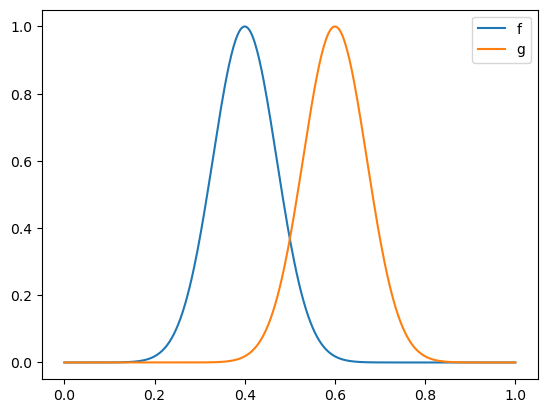

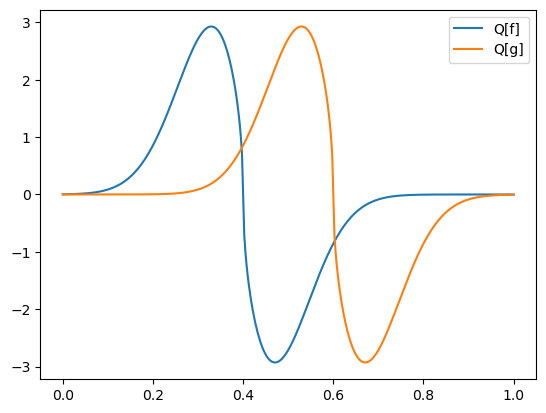

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from deepshape.curves import *
from utils import create_exp, SRSF, functionalqmap
from gradient_descent import gradient_descent
from dynamic import dynamic_reparametrization, find_path

k = 401
x = torch.linspace(0, 1, k)

f = create_exp(c=0.4)
g = create_exp(c=0.6)

# Plot the two functions.
plt.figure()
plt.plot(x, f(x), label='f')
plt.plot(x, g(x), label='g')
plt.legend()


# Plot the SRSFs of the two functions.
plt.figure()
q = SRSF(f)
r = SRSF(g)
plt.plot(x, q(x), label='Q[f]')
plt.plot(x, r(x), label='Q[g]')
plt.legend()

# plt.figure()
# q = FunctionalQmap(f)
# r = FunctionalQmap(g)
# plt.plot(x, q(x), label='Q[f]')
# plt.plot(x, r(x), label='Q[g]')
# plt.legend()

plt.show()

In [3]:
def remove_grad_requirement(network):
    for p in network.parameters():
        p.requires_grad = False

### 1.1 DeepShape


Finished training in 0.26767s


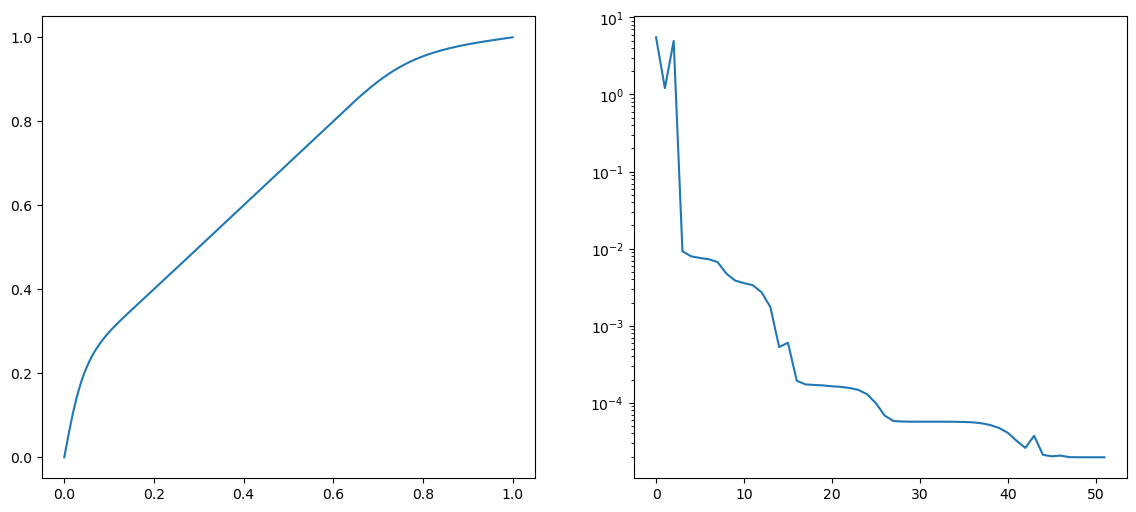

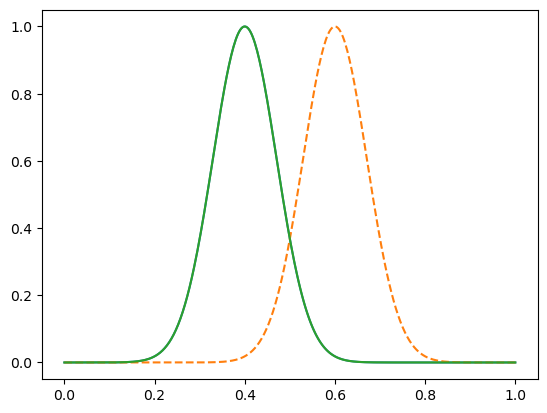

In [4]:
loss = CurveDistance(q, r, k=2048)
RN = CurveReparametrizer([
    SineSeries(5) for _ in range(5)
])
opt = torch.optim.LBFGS(RN.parameters(), line_search_fn='strong_wolfe', max_iter=100, max_eval=200)
error = reparametrize(RN, loss, opt, 1, Logger(0))
remove_grad_requirement(RN)

y = RN(x.view(-1, 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x, y)
ax2.semilogy(error)
plt.show()

plt.plot(x, f(x))
plt.plot(x, g(x), '--')
plt.plot(x, g(y))
plt.show()

### 1.2 Riemannian Gradient Descent 

Iter 	E         	|c|       	α         	δEi/E0    
    0	2.7629e+00	           	          	
    1	2.693258e+00	2.920800e-01	1.004897e+00	2.519344e-02
    2	2.529706e+00	5.598761e-01	5.779321e-01	5.919647e-02
    3	2.257923e+00	1.112751e+00	2.990465e-01	9.837023e-02
    4	1.895311e+00	1.923104e+00	1.700978e-01	1.312449e-01
    5	1.454725e+00	2.608643e+00	1.260252e-01	1.594671e-01
    6	9.694970e-01	2.963569e+00	1.125376e-01	1.756250e-01
    7	5.324891e-01	3.091508e+00	1.030828e-01	1.581720e-01
    8	2.102100e-01	2.722092e+00	1.133978e-01	1.166467e-01
    9	8.715054e-02	1.832055e+00	1.656566e-01	4.454055e-02
   10	8.316002e-02	2.487555e-01	4.720435e-01	1.444340e-03
   11	6.279748e-02	2.820177e-01	8.209053e-01	7.370084e-03
   12	5.706292e-02	8.897336e-01	1.756251e-01	2.075583e-03
   13	4.866267e-02	2.456234e-01	9.503899e-01	3.040414e-03
   14	3.844345e-02	9.115444e-01	1.683394e-01	3.698779e-03
   15	2.967583e-02	1.778682e-01	1.285412e+00	3.173381e-03
   16	2.158101e-02	7.578459e-01	1.00342

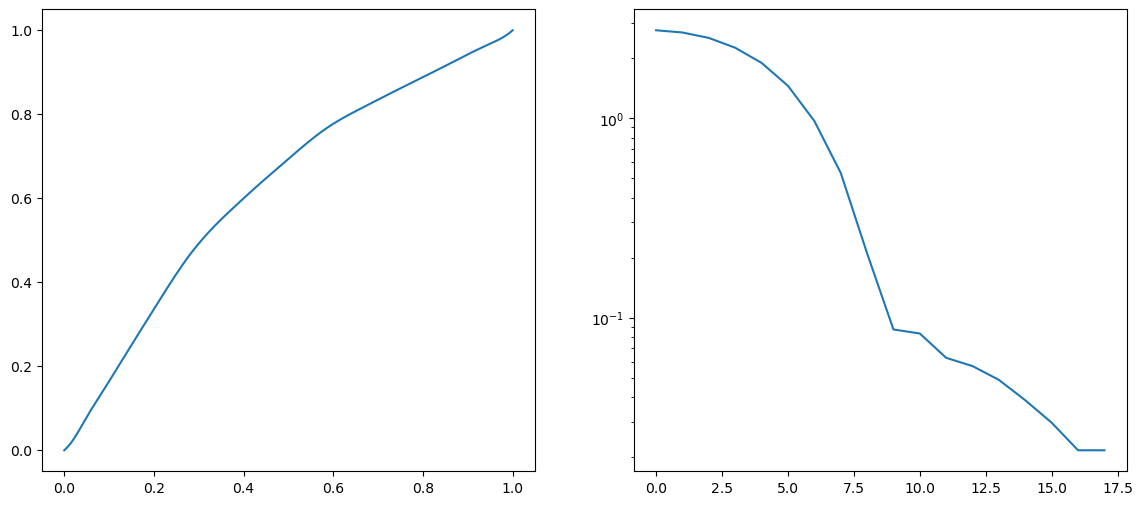

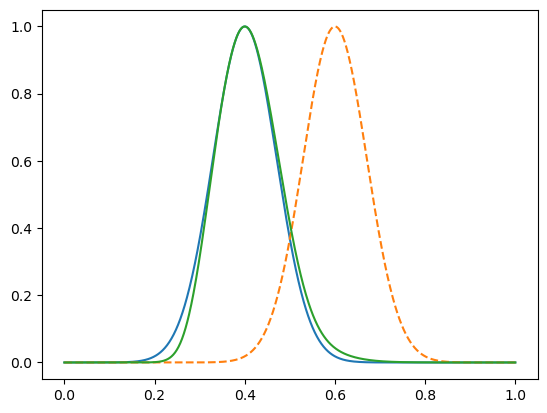

In [5]:
k = 1024
n = 10
x = torch.linspace(0, 1, k)
tic = time.time()
y, error = gradient_descent(q, r, k, n, rho=0.5, rtol=1e-6, gtol=1e-8, verbose=True)
toc = time.time()
print(f"Time spent: {toc - tic:.5f}s")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x, y)
ax2.semilogy(error)
plt.show()

plt.plot(x, f(x))
plt.plot(x, g(x), '--')
plt.plot(x, g(y))
plt.show()

#### Check Convergence with Respect to Number of Basis Functions

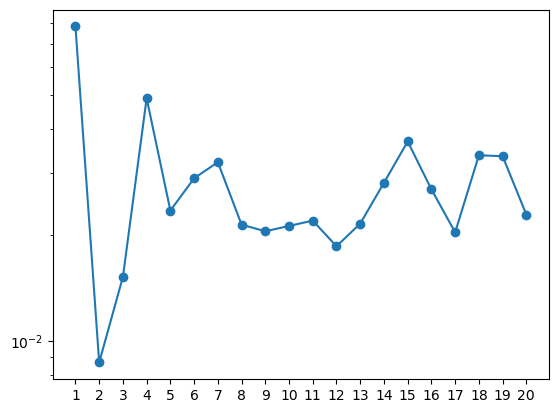

In [6]:
nmax = 20
E = np.nan * np.empty(nmax)
nlist = list(range(1, nmax+1))
print(f"[{' ' * nmax}] {0:>3}%", end='\r')
for ni in nlist:
    print(f"[{'=' * ni}{' ' * (nmax-ni)}] {100 * ni // nmax:>3}%", end='\r')
    _, e = gradient_descent(q, r, k, ni)
    E[ni-1] = e[-1]
    

plt.semilogy(list(range(1, nmax+1)), E, 'o-')
plt.xticks(nlist)
plt.show()

## 1.3 Dynamic Programming

In [7]:
from dynamic_programming import srsf_discrete, dynamic_reparametrization, find_path, interpolate_path, mse
from utils import SRSF
import time

In [8]:
n = 20
x = torch.linspace(0, 1, n+1)
Q, R = srsf_discrete(f(x)), srsf_discrete(g(x))

tic = time.time()
nodes, H = dynamic_reparametrization(Q, R)
toc = time.time()
print(f"Time spent: {toc - tic:.5f}s")

Time spent: 4.06596s


tensor(1.1253e-05, dtype=torch.float64)
tensor(0.0001)


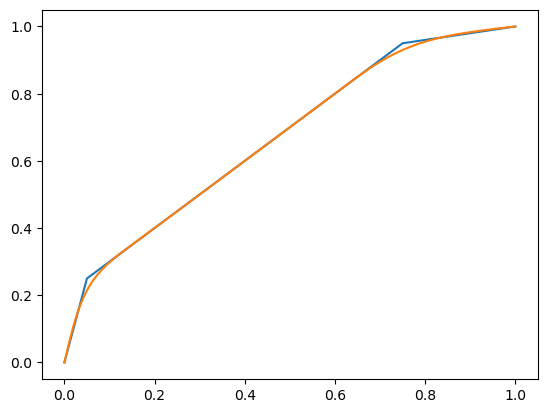

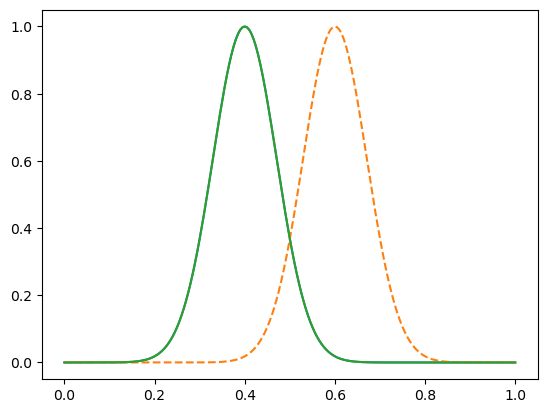

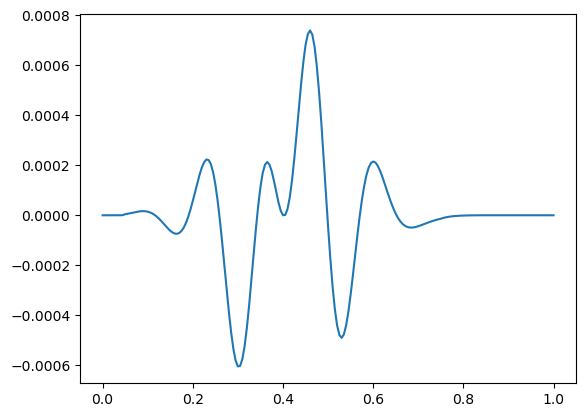

In [9]:
phi = interpolate_path(nodes, n)
print(mse(SRSF(f)(x), SRSF(lambda x: g(phi(x)))(x)))
print(mse(SRSF(f)(x), SRSF(lambda x: g(RN(x.view(-1, 1))).view(-1))(x)))


xx = torch.linspace(0, 1, 201)
plt.figure()
plt.plot(xx, phi(xx))
plt.plot(xx, RN(xx.view(-1, 1)))
plt.show()

plt.figure()
plt.plot(xx, f(xx))
plt.plot(xx, g(xx), '--')
plt.plot(xx, g(phi(xx)))
plt.show()

plt.figure()
plt.plot(xx, g(phi(xx)) - g(RN(xx.view(-1, 1))).squeeze())
plt.show()

## 2. Test Case 2: Curves

In [ ]:
from utils import circle, infinity, SRVT, logstep, compose, plot_curve, qmap


c1 = circle()
# c1 = infinity()
phi = logstep()
c0 = compose(c1, phi)
q = SRVT(c0)
r = SRVT(c1)
# q = qmap(c0)
# r = qmap(c1)


# Plot curves and transforms in common figure. 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_curve(c0, ax=ax1, dotpoints=41)
plot_curve(c1, npoints=0, ax=ax1, dotpoints=41)
plt.axis('equal')
plot_curve(q, ax=ax2)
plot_curve(r, ax=ax2)
plt.axis('equal')
plt.show()


# Plot two curves in separate subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_curve(c0, ax=ax1, dotpoints=41)
plot_curve(c1, ax=ax2, dotpoints=41)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_curve(c0, ax=ax, dotpoints=41)
ax.set_aspect('equal')
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
fig.savefig("./figures/target.pdf", bbox_inches="tight")



fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_curve(c1, ax=ax, dotpoints=41)
ax.set_aspect('equal')
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
fig.savefig("./figures/subject.pdf", bbox_inches="tight")

### 2.1 Deep Reparametrization

loss = CurveDistance(q, r, k=2048)
RN = CurveReparametrizer([
    SineSeries(6) for _ in range(6)
])
opt = torch.optim.LBFGS(RN.parameters(), line_search_fn='strong_wolfe', max_iter=300, max_eval=300)
ern = reparametrize(RN, loss, opt, 1, Logger(0))
remove_grad_requirement(RN)

k = 2048
x = torch.linspace(0, 1, k)
yrn = RN(x.view(-1, 1))

# Plot diffeomorphism and subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x, yrn)
ax1.plot(x, phi(x), 'k--')
ax2.semilogy(ern / ern[0])
plt.show()

# Perform reparametrization.
k = 2048
n = 6
x = torch.linspace(0, 1, k)
y, error = gradient_descent(q, r, k, n, verbose=True)

egd = 2 * error / (k-1)

# Plot diffeomorphism and subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x, y)
ax1.plot(x, phi(x), 'k--')
ax2.semilogy(error)
plt.show()


fig = plt.figure()
plt.plot(x, y, label="GD")
plt.plot(x, yrn, label="Deep", lw=2)
plt.plot(x, phi(x), 'k--', lw=1., label=r'$ \varphi $')
# plt.xlabel("$x$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.savefig("./figures/gd-deep-comparison-differomorphism.pdf", bbox_inches='tight')
plt.show()


Ngd = np.arange(1, egd.size+1)
Nrn = np.arange(1, ern.size+1)
fig = plt.figure()
plt.semilogy(Ngd, egd / egd[0], label="GD")
plt.semilogy(Nrn, ern / ern[0], label="Deep")
plt.legend()
plt.savefig("./figures/gd-deep-comparison-error-rel.pdf", bbox_inches='tight')
plt.show()

fig = plt.figure()
plt.semilogy(Ngd, egd, label="GD")
plt.semilogy(Nrn, ern, label="Deep")
plt.legend()
plt.savefig("./figures/gd-deep-comparison-error-abs.pdf", bbox_inches='tight')
plt.show()

# Perform reparametrization.
k = 2048
n = 6
x = torch.linspace(0, 1, k)
y, error = gradient_descent(q, r, k, n, verbose=True)


# Plot diffeomorphism and subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x, y)
ax1.plot(x, phi(x), 'k--')
ax2.semilogy(error)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_curve(c0, ax=ax1, dotpoints=21)
plt.plot(*c1(y))
plt.plot(*c1(y[::k//20]), 'o')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()

nmax = 20
E = np.nan * np.empty(nmax)
nlist = list(range(1, nmax+1))
print(f"[{' ' * nmax}] {0:>3}%", end='\r')
for ni in nlist:
    print(f"[{'=' * ni}{' ' * (nmax-ni)}] {100 * ni // nmax:>3}%", end='\r')
    _, e = gradient_descent(q, r, k, ni)
    E[ni-1] = e[-1]
    

plt.semilogy(list(range(1, nmax+1)), E, 'o-')
plt.xticks(nlist)
plt.show()

In [75]:
n = 20
nodes, H = dynamic_reparametrization(q, r, n)

path = find_path(nodes, n)
path_x = [pi[0] / n for pi in path]
path_y = [pi[1] / n for pi in path]


x = torch.linspace(0, 1, n+1)
X = torch.linspace(0, 1, 201)

plt.figure()
plt.plot(path_x, path_y, 'r')
plt.show()

plt.figure()
plt.plot(path_x, path_y, 'r')
plt.plot(torch.linspace(0, 1, y.shape[0]), y)
plt.plot(x, phi(x), 'k--')
plt.show()

TypeError: dynamic_reparametrization() takes 2 positional arguments but 3 were given

In [1]:
def offset_zero(H, val=10.):
    A = np.zeros_like(H)
    A[0, 0] = H.mean()
    return A

c = plt.contourf(np.log(H+offset_zero(H)), vmax=10, levels=20)
plt.plot(np.array(path_x) * (H.shape[0] - 1), np.array(path_y) * (H.shape[1] - 1), 'k')
plt.colorbar(c)
plt.show()

NameError: name 'plt' is not defined